In [2]:
#Frequency of plane crash in countries
#Resource of csv file: https://www.kaggle.com/code/arathee2/analysing-airplane-crashes

from pyspark.sql import SparkSession
from pyspark.sql.functions import *
import pandas as pd
import spacy
import locationtagger
import seaborn as sns

In [3]:
#Create a session of spark
spark = SparkSession \
    .builder \
    .appName("how to read csv file") \
    .getOrCreate()

#Load the library for location
spacy.load("en_core_web_sm")

#Read the csv file
df = spark.read.csv("Airplane_Crashes_and_Fatalities_Since_1908.csv",header=True)

22/12/08 11:20:14 WARN Utils: Your hostname, Devashris-MacBook-Air.local resolves to a loopback address: 127.0.0.1; using 192.168.1.6 instead (on interface en0)
22/12/08 11:20:14 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


22/12/08 11:20:15 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [4]:
#Select the column using pyspark
summary_date = df.select("Date","Summary").where(df.Operator.contains("Military") == False)
summary_date = summary_date.dropna()
summary_date.show(truncate=True)

+----------+--------------------+
|      Date|             Summary|
+----------+--------------------+
|08/06/1913|The first fatal a...|
|05/25/1919|Caught fire in mi...|
|10/05/1920|Crashed while lan...|
|12/14/1920|Crashed into a tr...|
|09/06/1921|Crashed while mak...|
|01/14/1922|Crashed at Le Bou...|
|04/07/1922|A midair collisio...|
|12/24/1924|Shortly after tak...|
|06/25/1925|Crashed in poor w...|
|07/03/1926|Crashed while en ...|
|07/24/1926|    Weather related.|
|08/18/1926|Crashed in advers...|
|10/08/1926|    Weather related.|
|10/21/1926|The plane was on ...|
|03/24/1927|Stalled at low al...|
|04/15/1927|Crashed after an ...|
|04/22/1927|     Engine failure.|
|07/27/1927|     Engine failure.|
|08/22/1927|A broken wire led...|
|09/17/1927|The sightseeing p...|
+----------+--------------------+
only showing top 20 rows



In [5]:
#Create lists of the colums to search for locations
summary_loc = summary_date.select("Summary").toPandas()
summary_loc = list(summary_loc['Summary'])

date_loc = summary_date.select("Date").toPandas()
date_loc = list(date_loc['Date'])

location = []
date_country = []
country_count = {}

for index in range(len(summary_loc)):
    place_entity = locationtagger.find_locations(text = summary_loc[index])
    for country in place_entity.countries:
        location.append(country)
        date_country.append(tuple((date_loc[index],country)))
        country_count[country] = 1 + country_count.get(country, 0)

date_country

[('08/06/1913', 'Canada'),
 ('04/07/1922', 'France'),
 ('04/29/1933', 'China'),
 ('07/27/1934', 'Germany'),
 ('07/20/1935', 'Switzerland'),
 ('06/09/1936', 'Sweden'),
 ('02/05/1938', 'Greenland'),
 ('07/29/1938', 'Guam'),
 ('08/24/1938', 'Hong Kong'),
 ('09/27/1944', 'Spain'),
 ('09/27/1944', 'France'),
 ('08/03/1945', 'France'),
 ('05/29/1947', 'Iceland'),
 ('07/13/1947', 'Puerto Rico'),
 ('08/02/1947', 'Argentina'),
 ('08/02/1947', 'Chile'),
 ('01/30/1948', 'Bermuda'),
 ('05/15/1948', 'France'),
 ('08/01/1948', 'Martinique'),
 ('08/01/1948', 'United States'),
 ('08/01/1948', 'Mauritania'),
 ('08/01/1948', 'France'),
 ('12/28/1948', 'Mexico'),
 ('01/17/1949', 'Bermuda'),
 ('01/17/1949', 'Jamaica'),
 ('08/06/1949', 'Ecuador'),
 ('08/15/1949', 'Ireland'),
 ('09/27/1949', 'Ecuador'),
 ('01/18/1950', 'Spain'),
 ('06/12/1950', 'Bahrain'),
 ('12/30/1952', 'China'),
 ('02/14/1953', 'Mexico'),
 ('03/20/1953', 'Japan'),
 ('08/09/1954', 'Bermuda'),
 ('12/18/1954', 'Jamaica'),
 ('03/26/1955', 'U

In [9]:
#Find countries whose counts are greater than 3
country_greater2 = set()
for country in location:
    if location.count(country) > 2:
        country_greater2.add(country)

country_greater2

{'Bermuda',
 'Canada',
 'China',
 'Ecuador',
 'France',
 'Germany',
 'Guam',
 'Hong Kong',
 'India',
 'Jamaica',
 'Japan',
 'Mexico',
 'Puerto Rico',
 'Spain',
 'Switzerland'}

In [10]:
#Create a pyspark dataframe and then make the data ready to plot
date_country_columns = ["Date","Country"]
date_country_spark = spark.createDataFrame(data=date_country, schema = date_country_columns)
date_country_spark = date_country_spark.filter(col("Country").isin(country_greater2))
date_country_panda = date_country_spark.toPandas()
date_country_panda["Date"] = pd.to_datetime(date_country_panda["Date"])

date_country_panda.dtypes

Date       datetime64[ns]
Country            object
dtype: object

Text(0.5, 1.0, 'Frequency of airplane crash by Country')

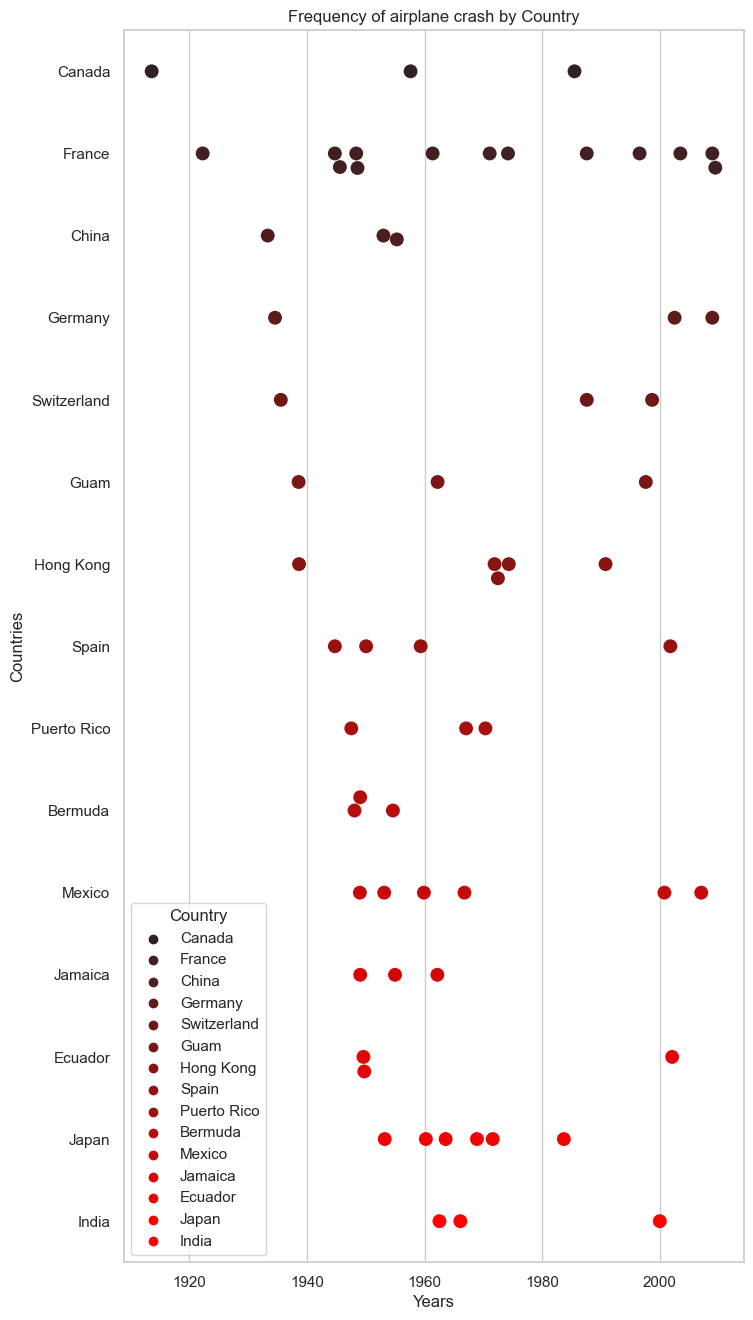

In [18]:
#Plot the data here
sns.set_theme(style="whitegrid", rc={'figure.figsize': (8, 16)})
plot = sns.swarmplot(x='Date', y='Country', data=date_country_panda,  hue="Country",palette='dark:red', size = 10)
plot.set_ylabel('Countries')
plot.set_xlabel('Years')
plot.set_title('Frequency of airplane crash by Country')